# Claim fraud detection

1. Loading the dataset
2. Exploratory Data Analysis
3. Data preprocessing - filling in of missing values, encoding, feature engineering
4. Undersampling/Oversampling
5. Predictive modeling

In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

### Loading the datsets downloaded from Kaggle
https://www.kaggle.com/datasets/mastmustu/insurance-claims-fraud-data

In [2]:
employee = pd.read_csv('data/employee_data.csv')
insurance = pd.read_csv('data/insurance_data.csv')
vendor = pd.read_csv('data/vendor_data.csv')

In [3]:
print('number of records in employee dataset:',employee.shape[0])
print('number of records in insurance dataset:',insurance.shape[0])
print('number of records in vendor dataset:',vendor.shape[0])

number of records in employee dataset: 1200
number of records in insurance dataset: 10000
number of records in vendor dataset: 600


Vendor dataset was not merged as atleast 70% of the ID's are missing in the claims dataset

In [4]:
df = pd.merge(insurance,employee,on="AGENT_ID",how="left")

In [5]:
df.isnull().sum()

TXN_DATE_TIME                  0
TRANSACTION_ID                 0
CUSTOMER_ID                    0
POLICY_NUMBER                  0
POLICY_EFF_DT                  0
LOSS_DT                        0
REPORT_DT                      0
INSURANCE_TYPE                 0
PREMIUM_AMOUNT                 0
CLAIM_AMOUNT                   0
CUSTOMER_NAME                  0
ADDRESS_LINE1_x                0
ADDRESS_LINE2_x             8505
CITY_x                        54
STATE_x                        0
POSTAL_CODE_x                  0
SSN                            0
MARITAL_STATUS                 0
AGE                            0
TENURE                         0
EMPLOYMENT_STATUS              0
NO_OF_FAMILY_MEMBERS           0
RISK_SEGMENTATION              0
HOUSE_TYPE                     0
SOCIAL_CLASS                   0
ROUTING_NUMBER                 0
ACCT_NUMBER                    0
CUSTOMER_EDUCATION_LEVEL     529
CLAIM_STATUS                   0
INCIDENT_SEVERITY              0
AUTHORITY_

## Exploratory Data Analysis
To understand the dataset and identify any patterns

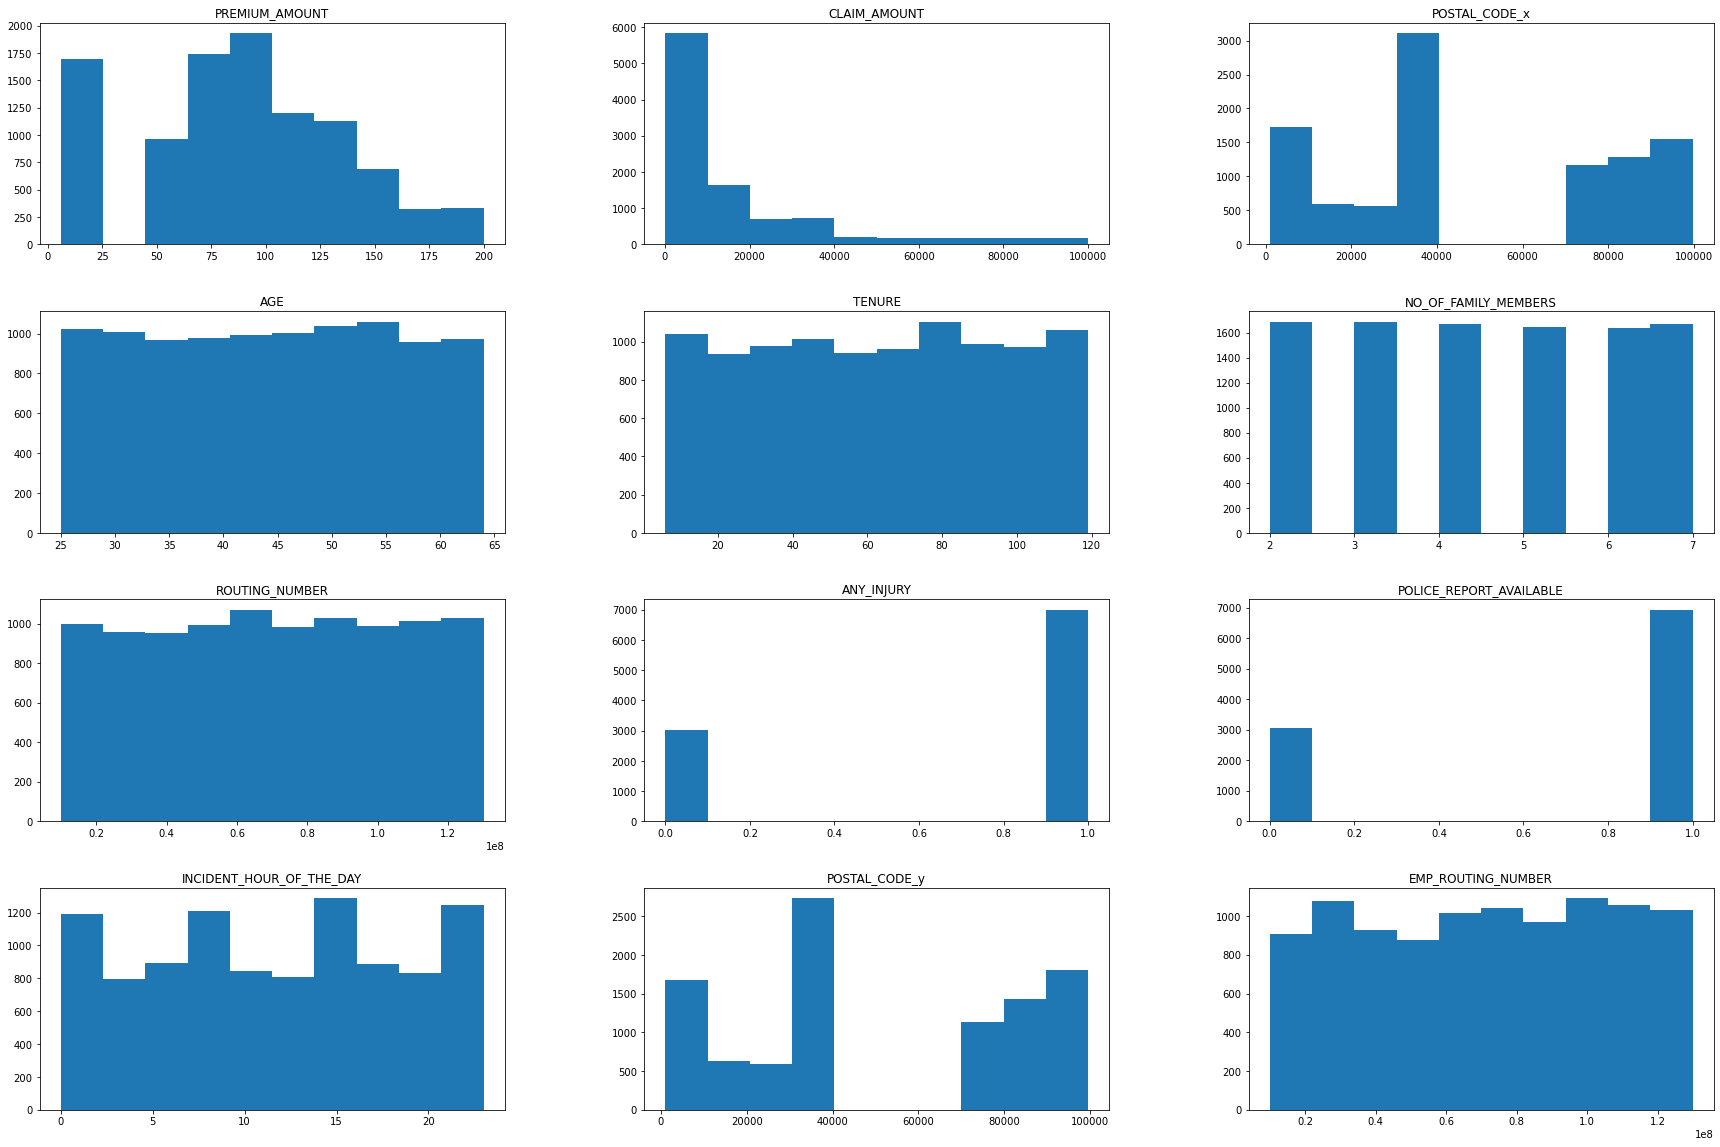

In [6]:
df.hist(bins=10, grid = False, figsize=(30,20));

<AxesSubplot:>

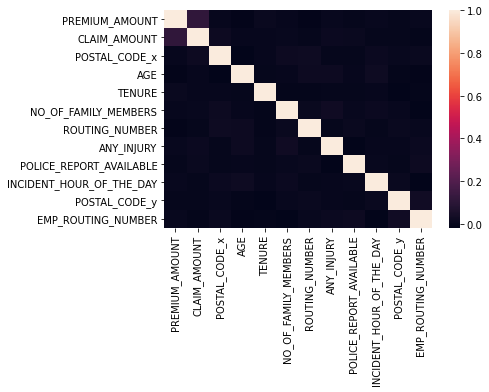

In [7]:
sns.heatmap(df.corr())

PREMIUM_AMOUNT and CLAIM_AMOUNT have a relatively significant positive correlation, implying that if premium is higher, amount claimed will be higher, which is a known relationship 

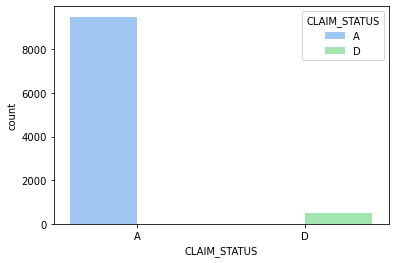

In [8]:
plt.style.use('seaborn-pastel')
ax = sns.countplot(x='CLAIM_STATUS', data=df, hue='CLAIM_STATUS')

There is a clear imbalance (~95% of the records belong to accepted claims) in the dataset. There's a higher number of records where the claims were accepted ('A') than declined ('D'). CLAIM_STATUS is the target variable we want to predict. The class imbalance will be handled during data preprocessing

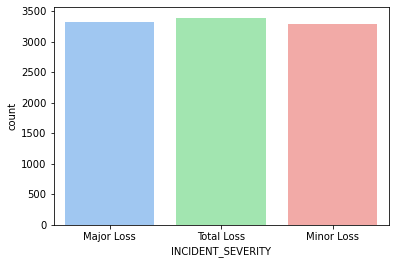

In [9]:
sns.countplot(x='INCIDENT_SEVERITY', data=df)
plt.show()

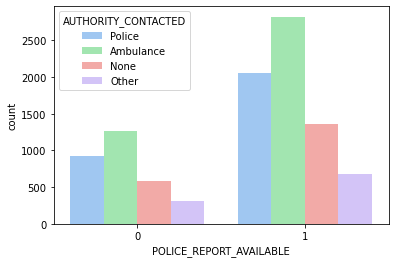

In [10]:
sns.countplot(x='POLICE_REPORT_AVAILABLE', hue='AUTHORITY_CONTACTED', data=df)
plt.show()

/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


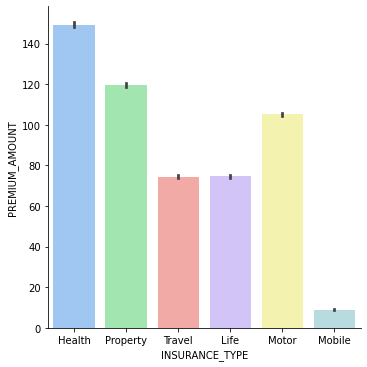

In [11]:
sns.factorplot(x="INSURANCE_TYPE",y="PREMIUM_AMOUNT",kind='bar',data=df)

/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


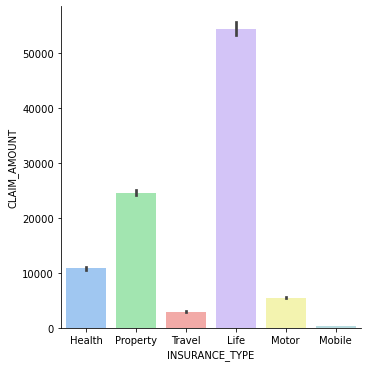

In [12]:
sns.factorplot(x="INSURANCE_TYPE",y="CLAIM_AMOUNT",kind='bar',data=df)

'Life' insurance type appears to have large values of claim amount on average

/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


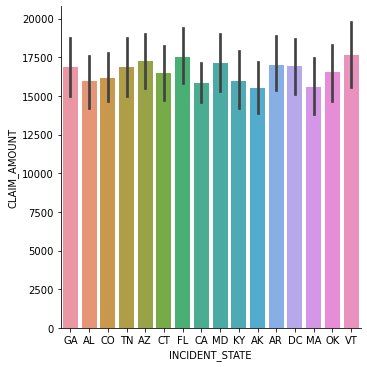

In [13]:
sns.factorplot(x="INCIDENT_STATE",y="CLAIM_AMOUNT",kind='bar',data=df)

The claim amount does seem to vary slightly across states on average (however, this is not conclusive as there is an uneven distribution of records across states) -- below

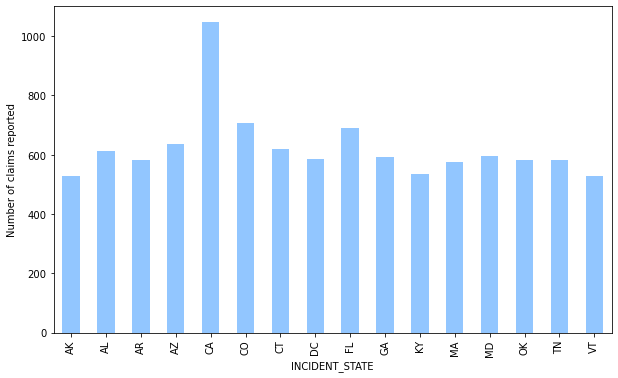

In [14]:
fig = plt.figure(figsize=(10,6))
ax = df.groupby('INCIDENT_STATE').CLAIM_STATUS.count().plot.bar(ylim=0)
ax.set_ylabel('Number of claims reported')
plt.show()

<AxesSubplot:xlabel='CUSTOMER_EDUCATION_LEVEL'>

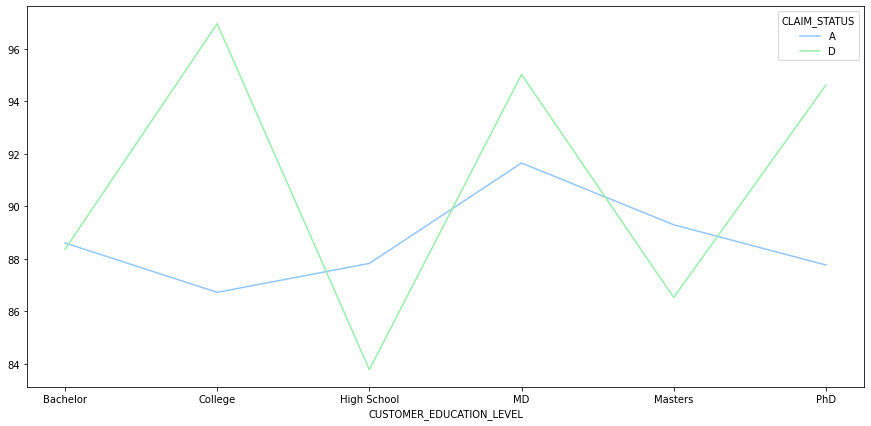

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
df_premium = df.groupby(['CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS']).mean()['PREMIUM_AMOUNT']
df_premium.unstack().plot(ax=ax)

From the above plot, it can be interpreted that policies with relatively higher premium values have been declined

<AxesSubplot:xlabel='CUSTOMER_EDUCATION_LEVEL'>

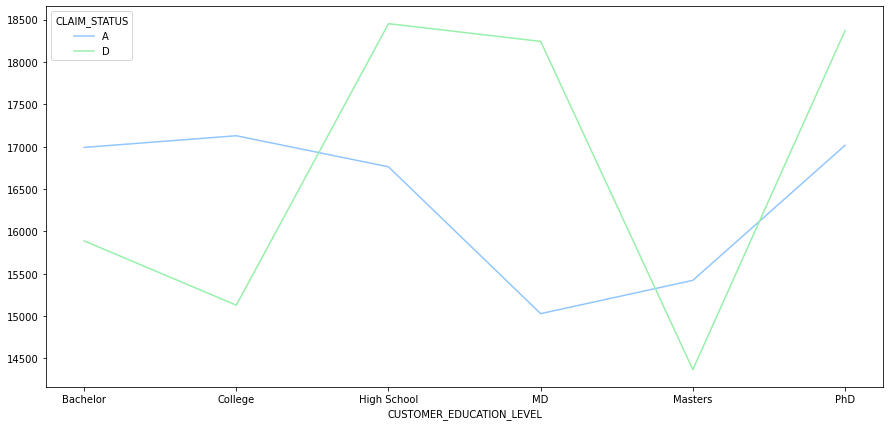

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
df_amount = df.groupby(['CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS']).mean()['CLAIM_AMOUNT']
df_amount.unstack().plot(ax=ax)

From the above plot, it can be interpreted that those claims with relatively higher claim amount have been declined

## Data preprocessing

### Filiing in of missing values
#### This is the first step to data cleaning as need to ensure there are no null values before any other processing
1. ADDRESS_LINE2 has over 85% of missing data, so we will drop it. We will be dropping VENDOR_ID as well as it is not relevant to our final prediction of fradulent claims

In [17]:
df.drop(columns=['ADDRESS_LINE2_x','ADDRESS_LINE2_y','VENDOR_ID'],inplace=True)

2. CITY will be filled using frequently occuring CITY in a given STATE

In [18]:
df['CITY_x'].fillna(df.groupby('STATE_x')['CITY_x']
                         .transform(lambda x: x.mode()[0]), inplace=True)
df['CITY_y'].fillna(df.groupby('STATE_y')['CITY_y']
                         .transform(lambda x: x.mode()[0]), inplace=True)

3. CUSTOMER_EDUCATION_LEVEL is filled using frequently occuring CUSTOMER_EDUCATION_LEVEL in a given CITY

In [19]:
df['CUSTOMER_EDUCATION_LEVEL'].fillna(df.groupby('STATE_x')['CUSTOMER_EDUCATION_LEVEL']
        .transform(lambda x: x.mode()[0]), inplace=True)

4. INCIDENT_CITY will be filled using frequently occuring INCIDENT_CITY in a given INCIDENT_STATE

In [20]:
df['INCIDENT_CITY'].fillna(df.groupby('INCIDENT_STATE')['INCIDENT_CITY'].transform(lambda x: x.mode()[0]), inplace=True)

### Feature selection - selecting most relevant features

Dropping below columns as they are redundant or irrelevant to our prediction model

In [21]:
df.drop(columns=['CUSTOMER_ID','TXN_DATE_TIME', 'TRANSACTION_ID', 'POLICY_NUMBER', 'CUSTOMER_NAME', 
                        'ADDRESS_LINE1_y', 'ADDRESS_LINE1_x','POSTAL_CODE_x', 'POSTAL_CODE_y' ,'AGENT_NAME', 
                        'SSN','ROUTING_NUMBER','ACCT_NUMBER','EMP_ROUTING_NUMBER','EMP_ACCT_NUMBER',
                ], inplace=True)

In [22]:
df.columns

Index(['POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'INSURANCE_TYPE',
       'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CITY_x', 'STATE_x', 'MARITAL_STATUS',
       'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS',
       'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS',
       'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY',
       'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE',
       'INCIDENT_STATE', 'INCIDENT_CITY', 'INCIDENT_HOUR_OF_THE_DAY',
       'AGENT_ID', 'DATE_OF_JOINING', 'CITY_y', 'STATE_y'],
      dtype='object')

### Encoding categorical/numeric features

Assuming the POLICY_EFF_DT is the data a policy has entered into force. To encode this feature, we will do feature extraction to create a new feature that will have the number of days elapsed between POLICY_EFF_DT and LOSS_DT

In [23]:
df['DAYS_LAPSED_SINCE_POLICY_EFF'] = (pd.to_datetime(df['LOSS_DT']) - pd.to_datetime(df['POLICY_EFF_DT'])).dt.days

To encode REPORT_DT, we will create a new features with the number of days elapsed between the LOSS_DT and REPORT_DT

In [24]:
df['DAYS_LAPSED_SINCE_LOSS'] = (pd.to_datetime(df['REPORT_DT']) - pd.to_datetime(df['LOSS_DT'])).dt.days

To encode DATE_OF_JOINING, we will create a new features with the number of days elapsed since the day employee joined and claims reported

In [25]:
df['DAYS_LAPSED_SINCE_EMP_JOINED'] = (pd.to_datetime(df['REPORT_DT']) - pd.to_datetime(df['DATE_OF_JOINING'])).dt.days

Dropping POLICY_EFF_FT, LOSS_DT, DATE_OF_JOINING as they have been encoded

In [26]:
df.drop(columns=['POLICY_EFF_DT','LOSS_DT','REPORT_DT','DATE_OF_JOINING'], inplace=True)

In [27]:
df.nunique()

INSURANCE_TYPE                     6
PREMIUM_AMOUNT                  6550
CLAIM_AMOUNT                     107
CITY_x                           412
STATE_x                           16
MARITAL_STATUS                     2
AGE                               40
TENURE                           114
EMPLOYMENT_STATUS                  2
NO_OF_FAMILY_MEMBERS               6
RISK_SEGMENTATION                  3
HOUSE_TYPE                         3
SOCIAL_CLASS                       3
CUSTOMER_EDUCATION_LEVEL           6
CLAIM_STATUS                       2
INCIDENT_SEVERITY                  3
AUTHORITY_CONTACTED                4
ANY_INJURY                         2
POLICE_REPORT_AVAILABLE            2
INCIDENT_STATE                    16
INCIDENT_CITY                    406
INCIDENT_HOUR_OF_THE_DAY          24
AGENT_ID                        1200
CITY_y                           203
STATE_y                           16
DAYS_LAPSED_SINCE_POLICY_EFF    3474
DAYS_LAPSED_SINCE_LOSS             5
D

We will use Binning to encode the numeric feature INCIDENT_HOUR_OF_THE_DAY for discretization

In [28]:
def encode_hour(hour):
    if hour >= 0 and hour <= 5:
        return 'Night'
    elif hour >= 6 and hour <= 11:
        return 'Morning'
    elif hour >= 12 and hour <= 17:
        return 'Afternoon'
    elif hour >= 18 and hour <= 23:
        return 'Evening'

df['INCIDENT_HOUR_OF_THE_DAY'] = df['INCIDENT_HOUR_OF_THE_DAY'].apply(encode_hour)

We will use One-Hot Encoding to encode the categorical features INSURANCE_TYPE, RISK_SEGMENTATION, HOUSE_TYPE, AUTHORITY_CONTACTED, SOCIAL_CLASS,CUSTOMER_EDUCATION_LEVEL,INCIDENT_SEVERITY, INCIDENT_HOUR_OF_THE_DAY

In [29]:
df = pd.get_dummies(df, columns=['INSURANCE_TYPE', 'HOUSE_TYPE', 'AUTHORITY_CONTACTED','RISK_SEGMENTATION',
                                'SOCIAL_CLASS','CUSTOMER_EDUCATION_LEVEL','INCIDENT_SEVERITY',
                                'INCIDENT_HOUR_OF_THE_DAY'])

We will use Binary Encoding to encode the categorical features MARITAL_STATUS, EMPLOYMENT_STATUS  as they are binary categories

In [30]:
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].map({'Y':1, 'N':0}) # assuming Y means Married
df['EMPLOYMENT_STATUS'] = df['EMPLOYMENT_STATUS'].map({'Y':1, 'N':0}) # assuming Y means employed

We use count encoding to encode the AGENT_ID as it is meaningful to get the number of times each agent has been inbolved in claim processing. Similarly, CITY_x, STATE_x, CITY_y, STATE_y, INCIDENT_STATE, INCIDENT_CITY can also be encoded using count encoding as it is valuable in knowing how often have claims been reported in each city/state

In [31]:
df['AGENT_ID'] = df['AGENT_ID'].map(df['AGENT_ID'].value_counts())
df['CITY_x'] = df['CITY_x'].map(df['CITY_x'].value_counts())
df['CITY_y'] = df['CITY_y'].map(df['CITY_y'].value_counts())
df['STATE_x'] = df['STATE_x'].map(df['STATE_x'].value_counts())
df['STATE_y'] = df['STATE_y'].map(df['STATE_y'].value_counts())
df['INCIDENT_STATE'] = df['INCIDENT_STATE'].map(df['INCIDENT_STATE'].value_counts())
df['INCIDENT_CITY'] = df['INCIDENT_CITY'].map(df['INCIDENT_CITY'].value_counts())

In [32]:
df.columns

Index(['PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CITY_x', 'STATE_x', 'MARITAL_STATUS',
       'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS',
       'CLAIM_STATUS', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE',
       'INCIDENT_STATE', 'INCIDENT_CITY', 'AGENT_ID', 'CITY_y', 'STATE_y',
       'DAYS_LAPSED_SINCE_POLICY_EFF', 'DAYS_LAPSED_SINCE_LOSS',
       'DAYS_LAPSED_SINCE_EMP_JOINED', 'INSURANCE_TYPE_Health',
       'INSURANCE_TYPE_Life', 'INSURANCE_TYPE_Mobile', 'INSURANCE_TYPE_Motor',
       'INSURANCE_TYPE_Property', 'INSURANCE_TYPE_Travel',
       'HOUSE_TYPE_Mortgage', 'HOUSE_TYPE_Own', 'HOUSE_TYPE_Rent',
       'AUTHORITY_CONTACTED_Ambulance', 'AUTHORITY_CONTACTED_None',
       'AUTHORITY_CONTACTED_Other', 'AUTHORITY_CONTACTED_Police',
       'RISK_SEGMENTATION_H', 'RISK_SEGMENTATION_L', 'RISK_SEGMENTATION_M',
       'SOCIAL_CLASS_HI', 'SOCIAL_CLASS_LI', 'SOCIAL_CLASS_MI',
       'CUSTOMER_EDUCATION_LEVEL_Bachelor', 'CUSTOMER_EDUCATION_LEVEL_College',
       'CUSTOMER_EDUCATI

We will used LabelEncoder to encode our target variable CLAIM_STATUS

In [33]:
label_encoder = preprocessing.LabelEncoder()
df['CLAIM_STATUS']= label_encoder.fit_transform(df['CLAIM_STATUS'])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PREMIUM_AMOUNT                        10000 non-null  float64
 1   CLAIM_AMOUNT                          10000 non-null  int64  
 2   CITY_x                                10000 non-null  int64  
 3   STATE_x                               10000 non-null  int64  
 4   MARITAL_STATUS                        10000 non-null  int64  
 5   AGE                                   10000 non-null  int64  
 6   TENURE                                10000 non-null  int64  
 7   EMPLOYMENT_STATUS                     10000 non-null  int64  
 8   NO_OF_FAMILY_MEMBERS                  10000 non-null  int64  
 9   CLAIM_STATUS                          10000 non-null  int64  
 10  ANY_INJURY                            10000 non-null  int64  
 11  POLICE_REPORT_AV

In [35]:
df['CLAIM_STATUS'].value_counts()

0    9497
1     503
Name: CLAIM_STATUS, dtype: int64

In [36]:
df.shape

(10000, 52)


## Undersampling

We are reducing number of sample of the class with a higher number of records in the dataset (ie) in this case its where CLAIM_STATUS = A, so as to balance the dataset

In [37]:
df_1 = df[df['CLAIM_STATUS'] == 0].sample(503)
df_2 = df[df['CLAIM_STATUS'] == 1].sample(503)
df_sample = df_1
df_sample = df_sample.append(df_2, ignore_index = True)
df_sample = sklearn.utils.shuffle(df_sample)

In [38]:
X_sample = df_sample.drop(columns=['CLAIM_STATUS'])
y_sample = df_sample['CLAIM_STATUS']

### Train-test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.20, random_state=42,shuffle=True)

In [40]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)

### Predictive modelling

In [41]:
print("Support Vector Classifier")
svc = SVC(kernel='linear', C=1, gamma=1)
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test,preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Support Vector Classifier
f1_score:  0.6464646464646464
accuracy:  0.4801980198019802
precision:  0.4824120603015075
recall:  0.9795918367346939


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [42]:
print("Random Forest Classifier")
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Random Forest Classifier
f1_score:  0.4673913043478261
accuracy:  0.5148514851485149
precision:  0.5
recall:  0.4387755102040816


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Undersampling the data is giving poor predictions


## Oversampling (SMOTE)

We are increasing samples of the class with a lower number of records in the dataset (ie) in this case its where CLAIM_STATUS=D, so as to balance the dataset. We use Synthetic Minority Oversampling TEchnique (SMOTE) for this purpose

### Train-test split

In [43]:
X = df.drop(columns=['CLAIM_STATUS'])
y = df['CLAIM_STATUS']

In [44]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42,shuffle=True)

In [46]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)

### Predictive modelling

In [47]:
print("Support Vector Classifier")
svc = SVC(kernel='linear', C=1, gamma=1)
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Support Vector Classifier


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


f1_score:  0.8289514382926075
accuracy:  0.8544353777309819
precision:  1.0
recall:  0.7078711040676176


In [48]:
print("Logistic Regression")
logreg2= LogisticRegressionCV(solver='lbfgs', cv=10)
logreg2.fit(X_train, y_train)
preds = logreg2.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Logistic Regression
f1_score:  0.6007416563658837
accuracy:  0.48986575414582784
precision:  0.49240121580547114
recall:  0.7702060221870047


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


In [49]:
print("Decision Tree Classifier")
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Decision Tree Classifier
f1_score:  0.7189728958630529
accuracy:  0.6370097394051066
precision:  0.5852687458526875
recall:  0.9318541996830428


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [50]:
print("Random Forest Classifier")
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Random Forest Classifier
f1_score:  0.8551599275799637
accuracy:  0.8736509607791524
precision:  0.9971850809289233
recall:  0.7485472794506075


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [51]:
print("Ada Boost Classifier")
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
preds = ab.predict(X_test)
score = f1_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print('f1_score: ', score)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)

Ada Boost Classifier
f1_score:  0.8886961549580804
accuracy:  0.8986575414582785
precision:  0.9814814814814815
recall:  0.8119387216059165


/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


Ada Boost, Random Forest are performing better than Decision Tree and this must be because they are ensemble classifiers

After exploring both the techniques we observe that Oversampling is performing relatively better than Undersampling. This could be because the samples chosen of the majority class may be biased. We are also losing out on a huge number of data points of the majority class in the process. However, it is important to note that Overfitting works well in this case, but may not be the best choice always as it is susceptible to overfitting.